In [313]:
import pandas as pd
import numpy as np
import plotly.express as px
from autots import AutoTS
import matplotlib.pyplot as plt
import statsmodels.api as smapi
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [119]:
data = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/COVID19%20data%20for%20overall%20INDIA.csv', parse_dates=['Date_YMD']).set_index('Date_YMD')
print(data)

                       Date  Daily Confirmed  Daily Deceased
Date_YMD                                                    
2020-01-30  30 January 2020                1               0
2020-01-31  31 January 2020                0               0
2020-02-01  1 February 2020                0               0
2020-02-02  2 February 2020                1               0
2020-02-03  3 February 2020                1               0
...                     ...              ...             ...
2022-01-14  14 January 2022           266518             621
2022-01-15  15 January 2022           271202             314
2022-01-16  16 January 2022           258089             385
2022-01-17  17 January 2022           238018             310
2022-01-18  18 January 2022           282970             441

[720 rows x 3 columns]


In [120]:
data=data.drop(columns=['Date', 'Daily Confirmed'])
print(data.head())

            Daily Deceased
Date_YMD                  
2020-01-30               0
2020-01-31               0
2020-02-01               0
2020-02-02               0
2020-02-03               0


<AxesSubplot:xlabel='Date_YMD'>

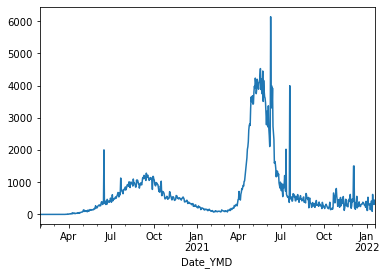

In [241]:
data['Daily Deceased'].plot()

In [331]:
data_train = data.iloc[:-10, :]
data_test = data.iloc[-10:, :]
print(data_test)


            Daily Deceased
Date_YMD                  
2022-01-09             146
2022-01-10             277
2022-01-11             411
2022-01-12             411
2022-01-13              96
2022-01-14             621
2022-01-15             314
2022-01-16             385
2022-01-17             310
2022-01-18             441


### Hyperparameter Tuning for ARIMA Model

In [345]:
from sklearn.model_selection import TimeSeriesSplit
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

def model_evaluation(p, d, q):
    tcsv = TimeSeriesSplit(test_size=1, n_splits=8)
    array = np.array([])
    for train_index, test_index in tcsv.split(data_train):
        train_ds, test_ds = data.iloc[train_index, :], data.iloc[test_index, :]
        order = (p, d, q)
        model = smapi.tsa.arima.ARIMA(train_ds.values, order=order).fit()
        predictions = model.predict(start=len(train_ds), end=len(train_ds)+len(test_ds)-1)
        error = mean_squared_error(test_ds, predictions, squared=False)
        array = np.append(array, error)
    return np.mean(array)
best_score = model_evaluation(0, 0, 0)
for p in p_values:
    for d in d_values:
        for q in q_values:
            error = model_evaluation(p, d, q)
            order = (p, d, q)
            if error<best_score:
                best_score=error
                best_params = order
print('Best Root Mean Squared error is: %f' % best_score)
print('Best Parameters were: %s' % (best_params, ))
           

Best Root Mean Squared error is: 90.381617
Best Parameters were: (4, 1, 0)


#### Forecasting 10 Dates in one go 

In [346]:
model = smapi.tsa.arima.ARIMA(data_train, order=best_params).fit()
preds = model.predict(start=len(data_train), end=len(data)-1)
error = mean_squared_error(data_test, preds, squared=False)
print(error)

145.872082901815


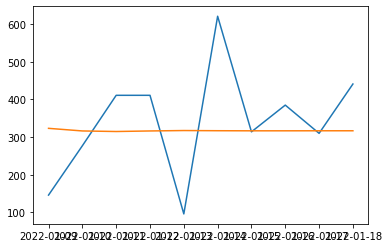

In [347]:
plt.plot(data_test)
plt.plot(preds)

#### Forecasting 1 Date at a time 

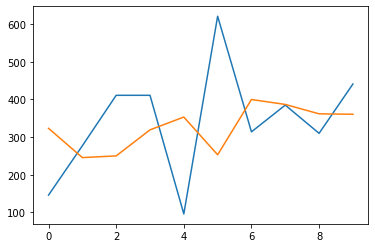

In [349]:
order = (4, 1, 0) 
tcsv = TimeSeriesSplit(test_size=1, n_splits=10)
predictions = []
for train_index, test_index in tcsv.split(data):
    train_ds, test_ds = data.iloc[train_index, :], data.iloc[test_index, :]
    model = smapi.tsa.arima.ARIMA(train_ds.values, order=order).fit()
    prediction = model.predict(start=len(train_ds), end=len(train_ds)+len(test_ds)-1)
    predictions.append(prediction)
plt.plot(data_test.values)
plt.plot(predictions)

In [350]:
print(mean_squared_error(predictions, data_test, squared=False))

168.75285403256302
